<a href="https://colab.research.google.com/github/SergeyShchus/OSM/blob/main/Notebook/OSMX_3_get_street_networks_by_place_name.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install osmnx

In [2]:
import osmnx as ox

%matplotlib inline
ox.__version__

'1.1.2'

OSMnx lets you download street network data and build topologically corrected multidigraphs, project to UTM and plot the networks, and save the street network as SVGs, GraphML files, .osm files, shapefiles, or geopackages for later use. The street networks are directed and preserve one-way directionality. API responses can be cached locally so OSMnx doesn't have to request the same data from the API multiple times: saving bandwidth, increasing speed, and enabling reproducibility.

You can download a street network by providing OSMnx any of the following:

a bounding box
a lat-long point plus a distance (either distance along the network, or cardinal)
an address plus a distance (either distance along the network, or cardinal)
a place name or list of place names (for OSMnx to automatically geocode and get the boundary of)
a polygon of the desired street network's boundaries
You can also specify several different built-in network types:

drive - get drivable public streets (but not service roads)
drive_service - get drivable streets, including service roads
walk - get all streets and paths that pedestrians can use (this network type ignores one-way directionality)
bike - get all streets and paths that cyclists can use
all - download all non-private OSM streets and paths
all_private - download all OSM streets and paths, including private-access ones
Or you can define your own fine-tuned network type using OSMnx's custom_filter parameter (to get just highways, or railways, canals, etc).

## 1. Query/download place boundaries
The graph_from_place function uses place boundary geocoding logic to find the network within your place's boundary. Let's look briefly at this place boundary querying before we get to street networks. You can download by cities, neighborhoods, boroughs, counties, states, or countries: anything with geocodable polygon boundaries in OSM's database. Notice the polygon geometries represent political boundaries, not physical/land boundaries. OSMnx will turn your geocoded place (or multiple places) boundaries into a geopandas GeoDataFrame.

<AxesSubplot:>

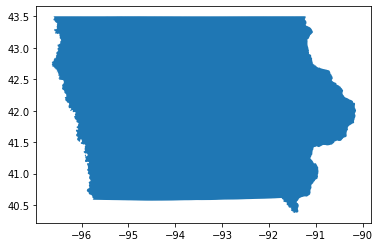

In [10]:

# states
gdf = ox.geocode_to_gdf("Iowa")
gdf.plot()

<AxesSubplot:>

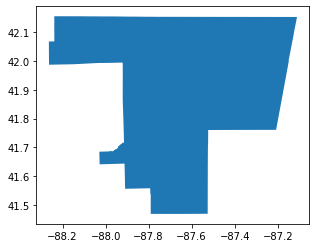

In [12]:
# neighborhoods or boroughs
gdf = ox.geocode_to_gdf("Manhattan, New York, New York, USA")

# counties
gdf = ox.geocode_to_gdf("Cook County, Illinois, United States")
gdf.plot()

<AxesSubplot:>

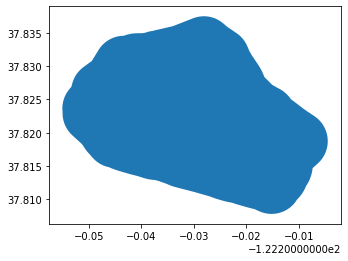

In [11]:
# you can also buffer the place boundaries (0.5 km in this example)
gdf = ox.geocode_to_gdf("Piedmont, California, USA", buffer_dist=500)
gdf.plot()

<AxesSubplot:>

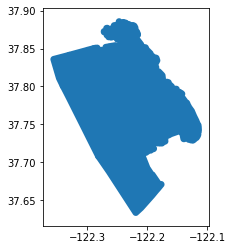

In [13]:
# you can get multiple places in a single query
gdf = ox.geocode_to_gdf(["United Kingdom", "Ireland"])

# or optionally buffer them
places = [
    "Berkeley, California, USA",
    "Oakland, California, USA",
    "Piedmont, California, USA",
    "Emeryville, California, USA",
    "Alameda, Alameda County, CA, USA",
]
gdf = ox.geocode_to_gdf(places, buffer_dist=500)
gdf.plot()

<AxesSubplot:>

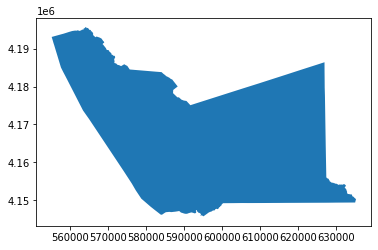

In [14]:
# oops, this gets the county of alameda rather than the city!
alameda1 = ox.geocode_to_gdf("Alameda, California, USA")

# this gets the city of alameda
alameda2 = ox.geocode_to_gdf(
    {
        "city": "Alameda",
        "county": "Alameda County",
        "state": "California",
        "country": "USA",
    }
)

# the city is a very small part of the county
alameda1 = ox.project_gdf(alameda1)
alameda2 = ox.project_gdf(alameda2)
alameda2.area.iloc[0] / alameda1.area.iloc[0]
alameda1.plot()

In [9]:
mexico = ox.geocode_to_gdf("Mexico", which_result=1)
type(mexico["geometry"].iloc[0])

shapely.geometry.multipolygon.MultiPolygon

<AxesSubplot:>

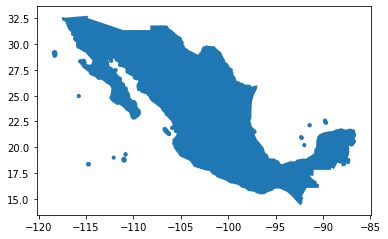

In [15]:
mexico.plot()

In [16]:
# let the geocoder find the first Polygon/MultiPolygon result
mexico = ox.geocode_to_gdf("Mexico", which_result=None)
type(mexico["geometry"].iloc[0])

shapely.geometry.multipolygon.MultiPolygon

In [17]:
# instead of a string, you can pass a dict containing a structured query for better precision
mexico = ox.geocode_to_gdf({"country": "Mexico"})
type(mexico["geometry"].iloc[0])

shapely.geometry.multipolygon.MultiPolygon

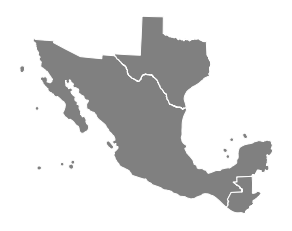

In [18]:
# you can pass multiple queries with mixed types (dicts and strings)
mx_gt_tx = ox.geocode_to_gdf([{"country": "Mexico"}, "Guatemala", {"state": "Texas"}])
mx_gt_tx = ox.project_gdf(mx_gt_tx)
ax = mx_gt_tx.plot(fc="gray", ec="w")
_ = ax.axis("off")

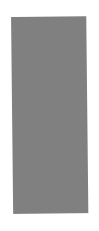

In [21]:
france = ox.geocode_to_gdf("France", which_result=2)
france = ox.project_gdf(france)
ax = france.plot(fc="gray", ec="none")
_ = ax.axis("off")

## 2. Get street networks by place name

In [24]:
# get the walking network for piedmont
G = ox.graph_from_place("Piedmont, California, USA", network_type="walk")

In [25]:
# you can also get a network with a buffer distance (meters) around the place
G = ox.graph_from_place("Piedmont, California, USA", network_type="walk", buffer_dist=200)

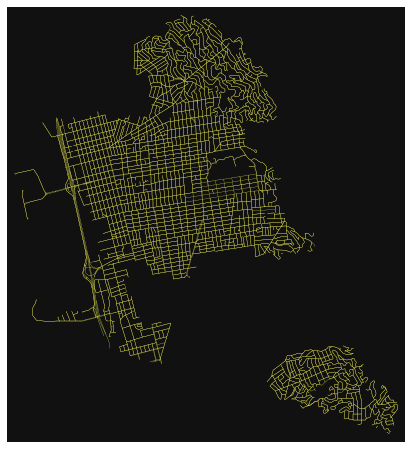

In [26]:
# create a network from multiple places
places = [
    "Piedmont, California, USA",
    {"city": "Berkeley", "state": "California"},
    "Emeryville, California, USA",
]

# use retain_all to keep all disconnected subgraphs (e.g. if your places aren't contiguous)
G = ox.graph_from_place(places, network_type="drive", retain_all=True)
fig, ax = ox.plot_graph(G, node_size=0, edge_color="#FFFF5C", edge_linewidth=0.25)

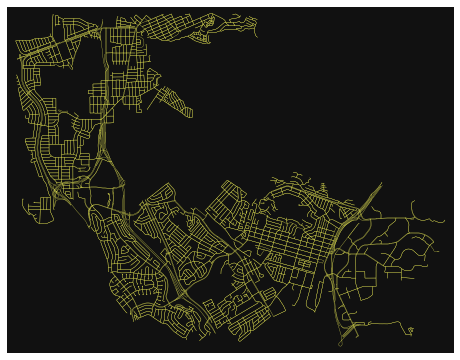

In [30]:
# or create a network from structured place queries
places = [
    {"city": "Daly City", "state": "California"},
    {"city": "South San Francisco", "state": "California"},
]
G = ox.graph_from_place(places, network_type="drive")
fig, ax = ox.plot_graph(G, node_size=0, edge_color="#FFFF5C", edge_linewidth=0.25)

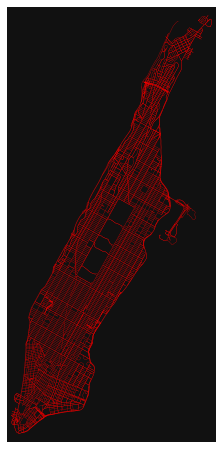

In [33]:
# get the network for the borough of manhattan
G = ox.graph_from_place("Manhattan, New York, New York, USA", network_type="drive")
fig, ax = ox.plot_graph(G, node_size=0, edge_color="red", edge_linewidth=0.25)

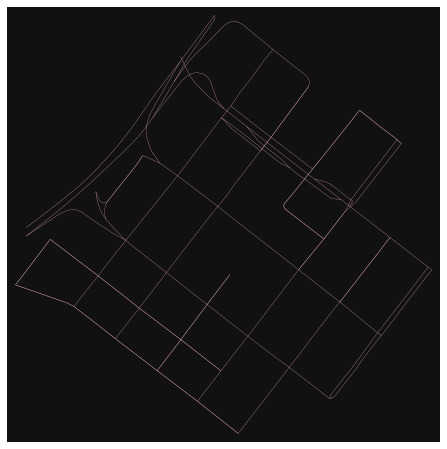

In [35]:
# get the network for the financial district neighborhood in downtown LA
place = "Financial District, Los Angeles, California, USA"
G = ox.graph_from_place(place, network_type="drive")
fig, ax = ox.plot_graph(G, node_size=0, edge_color="pink", edge_linewidth=0.25)

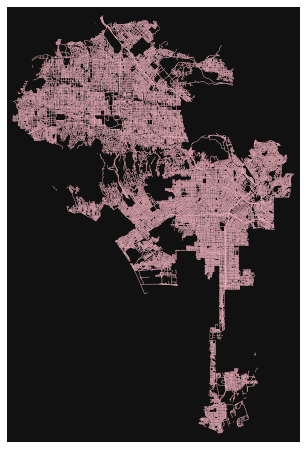

CPU times: user 4min 29s, sys: 2.04 s, total: 4min 31s
Wall time: 4min 31s


In [37]:
%%time
# get the network for all of LA
# takes a couple minutes to do all the downloading and processing
place = "Los Angeles, California, USA"
G = ox.graph_from_place(place, network_type="drive", simplify=False, retain_all=True)
fig, ax = ox.plot_graph(G, node_size=0, edge_color="pink", edge_linewidth=0.25)

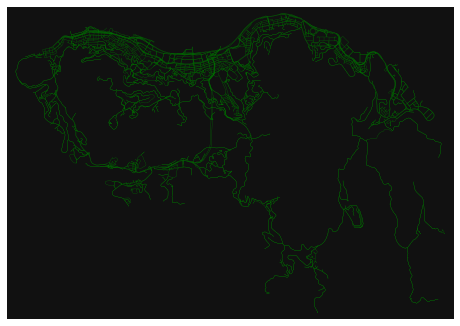

In [39]:
# create a network constrained to the shape of hong kong island
G = ox.graph_from_place("Hong Kong Island", network_type="drive")
fig, ax = ox.plot_graph(G, node_size=0, edge_color="green", edge_linewidth=0.25)

In [ ]:
# create a network constrained to the shape of hong kong island
G = ox.graph_from_place("Ukraine", network_type="drive")
fig, ax = ox.plot_graph(G, node_size=0, edge_color="green", edge_linewidth=0.25)